In [1]:
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams['font.family'] = 'serif'

In [33]:
import pandas as pd

In [35]:
df = pd.read_csv('/Users/linggeli/Downloads/simulation_data.csv')

In [41]:
df.head()

,X1,X2,X3,X4,X5,Y1,Y2,Y3,Y4,Y5,...,Y9,Y10,Y11,Y12,Y13,Y14,Y15,F1,F2,sim_id
0,0.855488024514697,0.948830,-1.152102,-0.7714545708253198,-0.298269,-0.004001,0.001171,-0.005288,0.010221,0.002132,...,0.003580,-0.001920,0.009646,0.002481,-0.004036,-0.014159,0.007200,0.009026,0.000068,1.0
1,-2.0739340538417914,-0.711068,-0.203650,-0.42628143789219597,1.163607,-0.019812,0.005163,-0.004374,0.065981,0.022950,...,-0.026406,0.004441,0.044195,0.008292,-0.050982,-0.077057,0.042986,0.042497,0.031071,1.0
2,0.25405064991486,-0.363499,1.045048,0.41258871649492873,-0.164769,-0.034781,0.008944,-0.003592,0.118710,0.042612,...,-0.054623,0.010409,0.076918,0.013809,-0.095307,-0.136577,0.076838,0.074193,0.060305,1.0
3,0.05678009063737152,0.338192,-1.612308,-0.09685066866740882,-1.628621,-0.048929,0.012520,-0.002939,0.168485,0.061145,...,-0.081118,0.015995,0.107858,0.019038,-0.137078,-0.192803,0.108803,0.104158,0.087813,1.0
4,-0.28087820156912746,0.605551,-0.782878,-0.8903972309360171,2.228624,-0.062276,0.015896,-0.002410,0.215381,0.078580,...,-0.105936,0.021208,0.137062,0.023988,-0.176360,-0.245820,0.138929,0.132435,0.113640,1.0


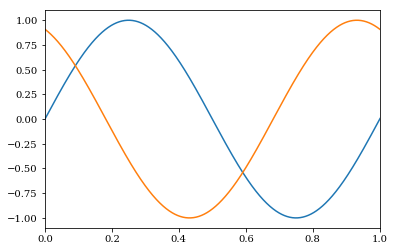

In [75]:
t = np.arange(0, 1.2, 0.001)
y1 = np.sin(2 * np.pi * t)
y2 = np.sin(2 * np.pi * t + 2.0)
plt.plot(t, y1)
plt.plot(t, y2)
plt.xlim(0, 1)
plt.show()

In [76]:
from scipy.linalg import expm, logm

### Data generation

In [110]:
def create_symmetric_matrix(upper, dim=5):
    """
    Create a symmetric matrix with elements in the upper triangle.
    
    Args
        upper: (numpy array) vector with concatenated rows in the upper triangle
        dim: (int) square matrix dimension
    """
    mat = np.zeros((dim, dim))
    current = 0
    for i in range(dim):  # fill in the upper triangle
        end = current + dim - i
        mat[i, i:] = upper[current:end]
        current = end
    for i in range(1, dim):  # fill in the lower triangle
        for j in range(i):
            mat[i, j] = mat[j, i]
    return mat

In [111]:
F = np.zeros((1200, 2))
F[:, 0] = y1
F[:, 1] = y2

In [113]:
B = np.random.normal(0, 0.5, [2, 15])

In [114]:
log_series = np.matmul(F, B)
print(log_series.shape)

(1200, 15)


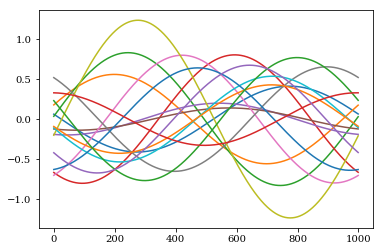

In [115]:
for j in range(15):
    plt.plot(log_series[:1000, j])
plt.show()

In [117]:
cov_series = np.zeros((1200, 5, 5))
time_series = np.zeros((1200, 5))
for i in range(1200):
    cov_series[i, :, :] = expm(create_symmetric_matrix(log_series[i, :]))
    time_series[i, :] = np.random.multivariate_normal(np.zeros(5), cov_series[i, :, :], 1)

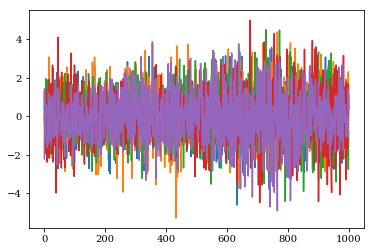

In [118]:
for j in range(5):
    plt.plot(time_series[:1000, j])
plt.show()

In [119]:
X = time_series[:1000, :]
print(X.shape)

(1000, 5)


### SW + PCA + VAR

In [120]:
from sklearn.decomposition import PCA
from statsmodels.tsa.api import VAR

In [121]:
def sliding_window(time_series, size=50, stride=1):
    """
    Calculate sliding window covariance Log-Euclidean vector time series.
    
    Args
        time_series: (numpy array) [t, n] t observations in time of n dimensional data
        size: (int) sliding window size
        stride: (int) sliding step size
    """
    t, n = X.shape
    #cov_series = np.zeros((t - size, n, n))
    log_series = np.zeros((t - size, int(0.5 * n * (n + 1))))
    for i in range(t - size):
        sliding_window = time_series[(i * stride):(i * stride + size), :]
        cov = np.cov(sliding_window, rowvar=False)
        #cov_series[i, :, :] = cov
        log_series[i, :] = logm(cov)[np.triu_indices(n)]
    return log_series

In [122]:
Y = log_series

In [123]:
log_series_hat = sliding_window(X)
pca = PCA(n_components=2)
components = pca.fit_transform(log_series_hat)

In [124]:
model = VAR(components)
results = model.fit(2)
fitted_components = np.zeros(components.shape)
fitted_components[:2, :] = components[:2, :]
fitted_components[2:, :] = results.fittedvalues
Y_hat = pca.inverse_transform(fitted_components)

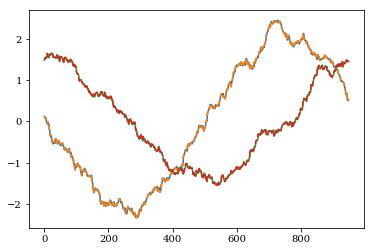

In [125]:
for j in range(2):
    plt.plot(fitted_components[:, j])
    plt.plot(components[:, j], '--')
plt.show()

In [126]:
total = log_series_hat.shape[0]
start = 25
mse = np.mean((Y[start:(start + total), :] - Y_hat) ** 2)
print(mse)

0.008636699924421077
